<a href="https://colab.research.google.com/github/snmsndhu/google_colab_files/blob/main/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Audio classification model

###Lib that i am going to use in this model are
1. Tensorflow
2. Tensorflow Datasets
3. Numply
4. Matplotlib


In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                              title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                        1MB  2024-04-10 09:48:38          15680        331  1.0              
sahirmaharajj/school-student-daily-attendance                    School Student Daily Attendance                    2MB  2024-04-29 19:29:56           3041         62  1.0              
mexwell/heart-disease-dataset                                    🫀 Heart Disease Dataset                          399KB  2024-04-08 09:43:49           7184        112  1.0              
kapturovalexander/time-series-for-online-store                   🏪🏬🪫 E

In [6]:
!kaggle datasets download -d mmoreaux/audio-cats-and-dogs

Dataset URL: https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs
License(s): CC-BY-SA-3.0
 97% 94.0M/97.0M [00:04<00:00, 25.4MB/s]
100% 97.0M/97.0M [00:04<00:00, 20.4MB/s]


In [7]:
! unzip /content/audio-cats-and-dogs.zip -d /content/data/

Archive:  /content/audio-cats-and-dogs.zip
  inflating: /content/data/cats_dogs/cat_1.wav  
  inflating: /content/data/cats_dogs/cat_10.wav  
  inflating: /content/data/cats_dogs/cat_100.wav  
  inflating: /content/data/cats_dogs/cat_101.wav  
  inflating: /content/data/cats_dogs/cat_102.wav  
  inflating: /content/data/cats_dogs/cat_103.wav  
  inflating: /content/data/cats_dogs/cat_105.wav  
  inflating: /content/data/cats_dogs/cat_106.wav  
  inflating: /content/data/cats_dogs/cat_107.wav  
  inflating: /content/data/cats_dogs/cat_108.wav  
  inflating: /content/data/cats_dogs/cat_109.wav  
  inflating: /content/data/cats_dogs/cat_11.wav  
  inflating: /content/data/cats_dogs/cat_110.wav  
  inflating: /content/data/cats_dogs/cat_112.wav  
  inflating: /content/data/cats_dogs/cat_113.wav  
  inflating: /content/data/cats_dogs/cat_114.wav  
  inflating: /content/data/cats_dogs/cat_115.wav  
  inflating: /content/data/cats_dogs/cat_116.wav  
  inflating: /content/data/cats_dogs/cat_11

In [8]:
## All the imports that we required for building the model

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [9]:
data_dir = "/content/data/cats_dogs/train"
test_dir = "/content/data/cats_dogs/test"

In [10]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory= data_dir,
    batch_size = 64,
    validation_split = 0.2,
    seed = 0,
    output_sequence_length = None,
    subset = "both"
)

Found 210 files belonging to 2 classes.
Using 168 files for training.
Using 42 files for validation.


In [11]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory= test_dir,
    batch_size = 64,
    seed = 0,
    output_sequence_length = None,

)

Found 67 files belonging to 2 classes.


In [12]:
label_names = np.array(train_ds.class_names)

In [13]:
label_names

array(['cat', 'dog'], dtype='<U3')

In [14]:
label_names

array(['cat', 'dog'], dtype='<U3')

In [15]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [16]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)


(64, 251509)
(64,)


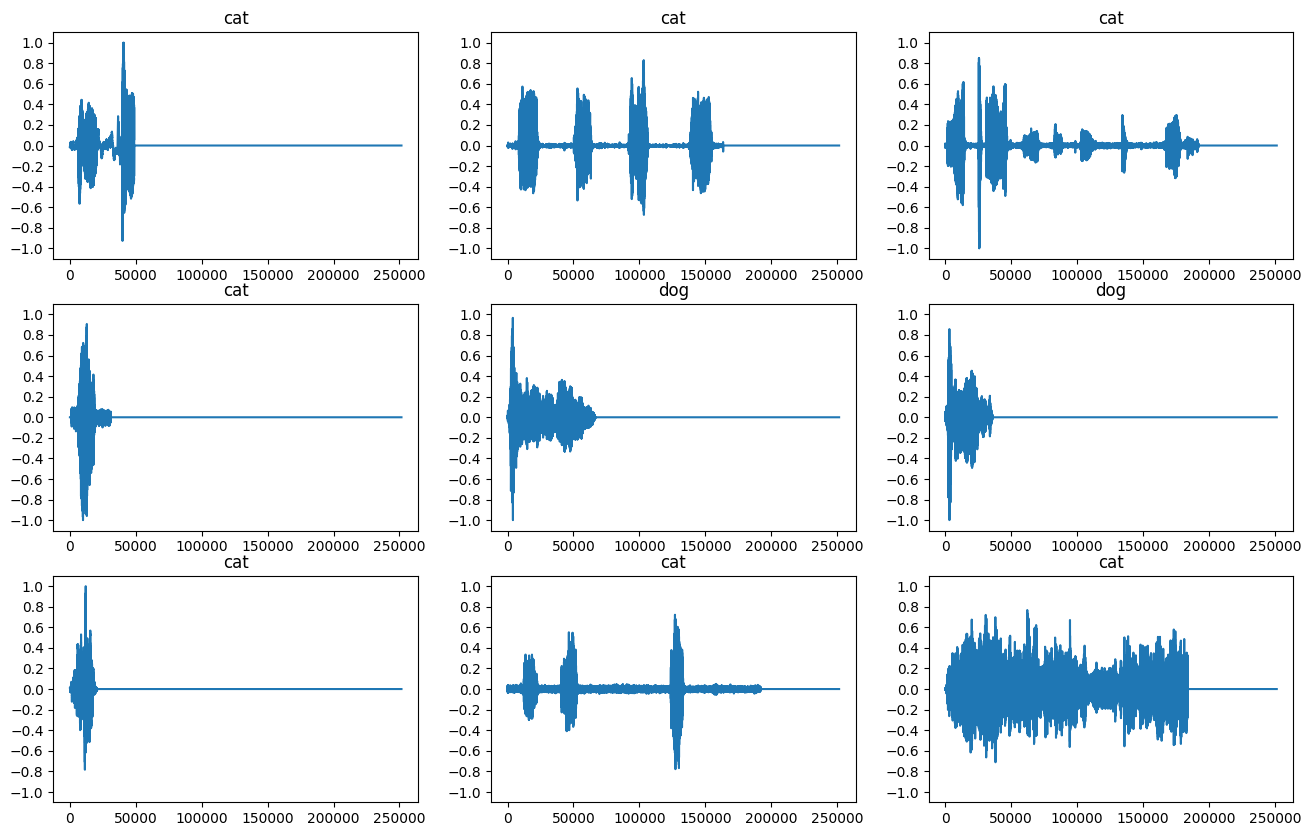

In [17]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [18]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [19]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: cat
Waveform shape: (251509,)
Spectrogram shape: (1963, 129, 1)
Audio playback


Label: cat
Waveform shape: (251509,)
Spectrogram shape: (1963, 129, 1)
Audio playback


Label: cat
Waveform shape: (251509,)
Spectrogram shape: (1963, 129, 1)
Audio playback


In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

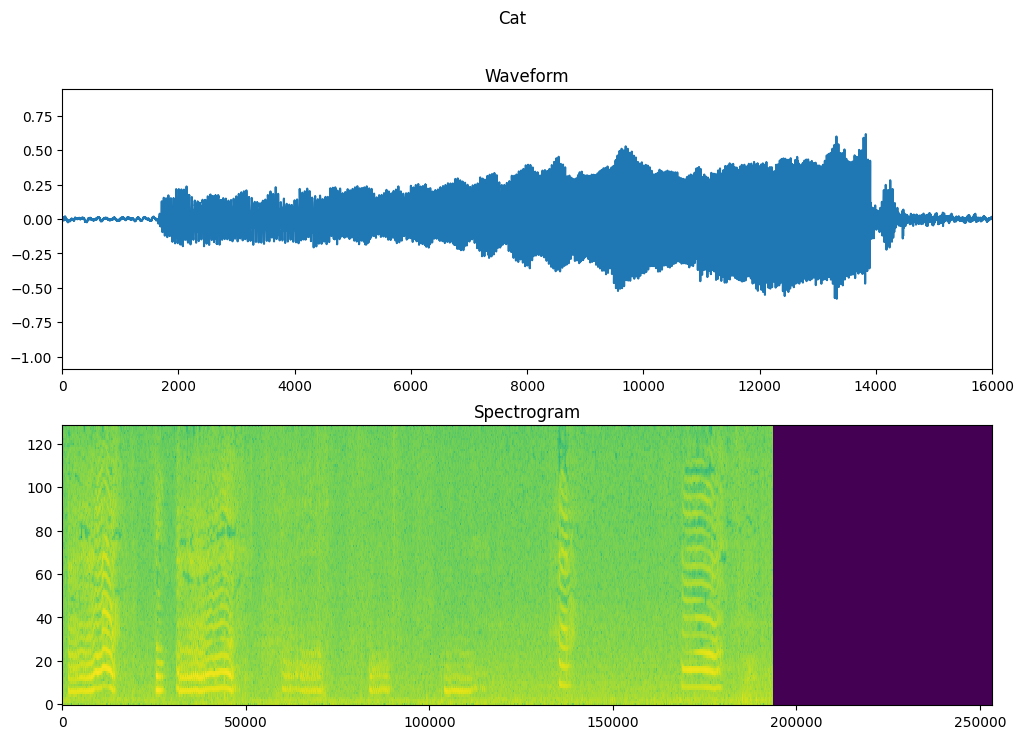

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [22]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [24]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [25]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [26]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (2149, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)          

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [28]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
3/3 [==============================] - 3s 930ms/step - loss: 0.7214 - accuracy: 0.5893 - val_loss: 0.4253 - val_accuracy: 0.9048
Epoch 2/10
3/3 [==============================] - 1s 182ms/step - loss: 0.5296 - accuracy: 0.8214 - val_loss: 0.3687 - val_accuracy: 0.8571
Epoch 3/10
3/3 [==============================] - 1s 170ms/step - loss: 0.4576 - accuracy: 0.8512 - val_loss: 0.3527 - val_accuracy: 0.8571
Epoch 4/10
3/3 [==============================] - 1s 195ms/step - loss: 0.3823 - accuracy: 0.8571 - val_loss: 0.2870 - val_accuracy: 0.9048
Epoch 5/10
3/3 [==============================] - 0s 163ms/step - loss: 0.3064 - accuracy: 0.8929 - val_loss: 0.2087 - val_accuracy: 0.9286
Epoch 6/10
3/3 [==============================] - 1s 183ms/step - loss: 0.2573 - accuracy: 0.9048 - val_loss: 0.1612 - val_accuracy: 0.9286
Epoch 7/10
3/3 [==============================] - 1s 278ms/step - loss: 0.2253 - accuracy: 0.9167 - val_loss: 0.1300 - val_accuracy: 0.9286
Epoch 8/10
3/3 [====

Text(0, 0.5, 'Accuracy [%]')

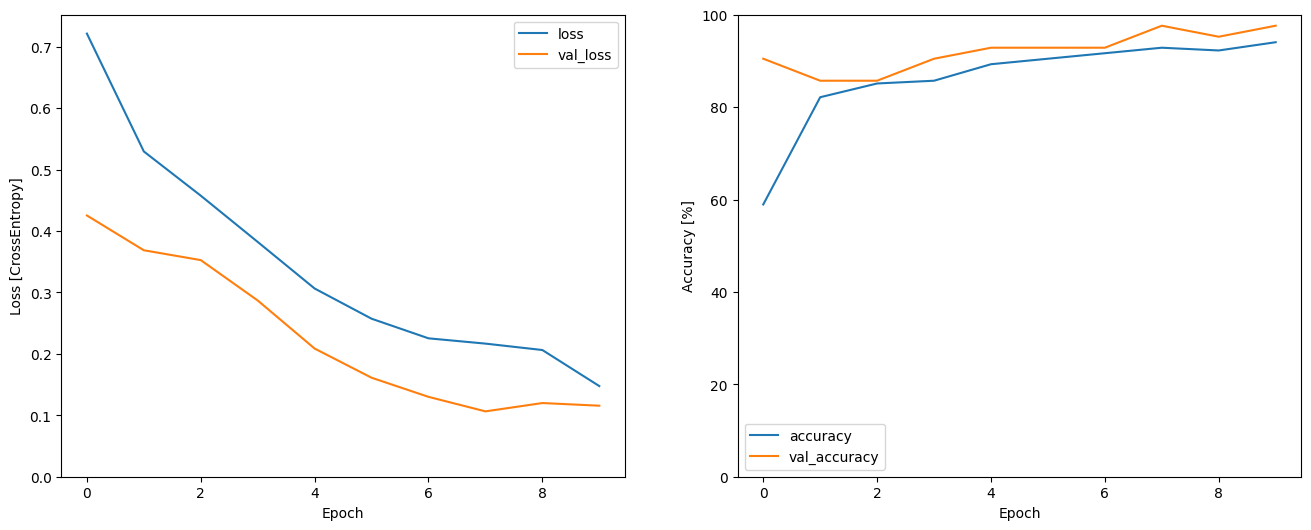

In [29]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')